<a href="https://colab.research.google.com/github/Sandeep-colab/forestfire/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import os


candidate_name = "Sandeep"

base_path = f"/content/ds_{candidate_name}"

os.makedirs(base_path, exist_ok=True)

open(f"{base_path}/notebook_1.ipynb", 'a').close()
os.makedirs(f"{base_path}/csv_files", exist_ok=True)
os.makedirs(f"{base_path}/outputs", exist_ok=True)
open(f"{base_path}/ds_report.pdf", 'a').close()
open(f"{base_path}/README.md", 'a').close()

print(f"{os.path.basename(base_path)}/")
print("    notebook_1.ipynb")
print("    csv_files/")
for f in os.listdir(f"{base_path}/csv_files"):
    print(f"        {f}")
print("    outputs/")
for f in os.listdir(f"{base_path}/outputs"):
    print(f"        {f}")
print("    ds_report.pdf")
print("    README.md")


ds_Sandeep/
    notebook_1.ipynb
    csv_files/
        daily.csv
        fear_greed.csv
        trades_clean.csv
        trader_data.csv
    outputs/
        top_active_accounts.png
        sentiment_frequency.png
        correlation_heatmap.png
        netpnl_7d.png
        netpnl_vs_sentiment.png
        winrate_by_sentiment.png
        avg_leverage_over_time.png
        total_volume_over_time.png
    ds_report.pdf
    README.md


In [44]:
!pip install --quiet gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [45]:

trader_data_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
fear_greed_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

# Paths
trader_path = f"{base_path}/csv_files/trader_data.csv"
sentiment_path = f"{base_path}/csv_files/fear_greed.csv"

# Download
!gdown --id {trader_data_id} -O {trader_path}
!gdown --id {fear_greed_id} -O {sentiment_path}


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_Sandeep/csv_files/trader_data.csv
100% 47.5M/47.5M [00:00<00:00, 103MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_Sandeep/csv_files/fear_greed.csv
100% 90.8k/90.8k [00:00<00:00, 62.9MB/s]


In [46]:
# Load trader data
trades = pd.read_csv(trader_path, low_memory=False, parse_dates=['Timestamp IST'])

# Load sentiment data
sent = pd.read_csv(sentiment_path, parse_dates=['date'])

# Normalize column names
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
sent.columns = sent.columns.str.strip().str.lower().str.replace(' ', '_')

trades.head(), sent.head()


(                                      account  coin  execution_price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    size_tokens  size_usd side     timestamp_ist  start_position direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    closed_pnl                                   transaction_hash     order_id  \
 0      

In [47]:
# From trades timestamp
if 'timestamp_ist' in trades.columns:
    trades['date'] = pd.to_datetime(trades['timestamp_ist'], dayfirst=True).dt.date
elif 'timestamp' in trades.columns:
    trades['date'] = pd.to_datetime(trades['timestamp'], dayfirst=True).dt.date
else:
    raise KeyError("No valid timestamp column found in trades dataset.")

# From sentiment dataset
sent['date'] = pd.to_datetime(sent['date'], dayfirst=True).dt.date

trades[['date']].head(), sent[['date']].head()


(         date
 0  2024-12-02
 1  2024-12-02
 2  2024-12-02
 3  2024-12-02
 4  2024-12-02,
          date
 0  2018-02-01
 1  2018-02-02
 2  2018-02-03
 3  2018-02-04
 4  2018-02-05)

In [48]:
# Drop duplicates
trades = trades.drop_duplicates()
sent = sent.drop_duplicates()

# Normalize 'side'
if 'side' in trades.columns:
    trades['side'] = trades['side'].astype(str).str.strip().str.lower()
    trades['side'] = trades['side'].replace({
        'buy': 'BUY', 'b': 'BUY',
        'sell': 'SELL', 's': 'SELL'
    })
    trades['side'] = trades['side'].where(trades['side'].isin(['BUY', 'SELL']), np.nan)

# Normalize symbol if exists
symbol_col = None
for col in ['symbol', 'coin', 'pair']:
    if col in trades.columns:
        symbol_col = col
        trades[symbol_col] = trades[symbol_col].astype(str).str.strip().str.upper()
        break

# Ensure closed_pnl numeric
if 'closed_pnl' in trades.columns:
    trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce').fillna(0.0)

# Save cleaned trades
clean_trades_path = f"{base_path}/csv_files/trades_clean.csv"
trades.to_csv(clean_trades_path, index=False)
print(f"Cleaned trades saved to: {clean_trades_path}")


Cleaned trades saved to: /content/ds_Sandeep/csv_files/trades_clean.csv


In [49]:
# Aggregate by date
daily = trades.groupby('date').agg(
    trade_count=('account', 'count'),
    total_volume=('size_usd', 'sum'),
    net_pnl=('closed_pnl', 'sum'),
    avg_leverage=('leverage', 'mean') if 'leverage' in trades.columns else ('closed_pnl', 'mean'),
    win_rate=('closed_pnl', lambda x: (x > 0).sum() / len(x)),
    median_size=('size_usd', 'median'),
    active_accounts=('account', 'nunique'),
).reset_index()

# Merge sentiment
daily = daily.merge(sent[['date', 'classification']], on='date', how='left')

# Map sentiment to numeric
sentiment_map = {
    'Extreme Greed': 1,
    'Greed': 1,
    'Neutral': 0,
    'Fear': -1,
    'Extreme Fear': -1
}
daily['sentiment'] = daily['classification'].map(sentiment_map).fillna(0)

# Save
daily_path = f"{base_path}/csv_files/daily.csv"
daily.to_csv(daily_path, index=False)
print(f"Daily aggregated data saved to: {daily_path}")

daily.head()


Daily aggregated data saved to: /content/ds_Sandeep/csv_files/daily.csv


,date,trade_count,total_volume,net_pnl,avg_leverage,win_rate,median_size,active_accounts,classification,sentiment
0,2023-05-01,3,477.00,0.000000,0.000000,0.000000,156.390,1,Greed,1.0
1,2023-12-05,9,50005.83,0.000000,0.000000,0.000000,1935.950,1,Extreme Greed,1.0
2,2023-12-14,11,113203.35,-205.434737,-18.675885,0.363636,8677.280,1,Greed,1.0
3,2023-12-15,2,10609.95,-24.632034,-12.316017,0.000000,5304.975,1,Greed,1.0
4,2023-12-16,3,15348.77,0.000000,0.000000,0.000000,4680.140,1,Greed,1.0


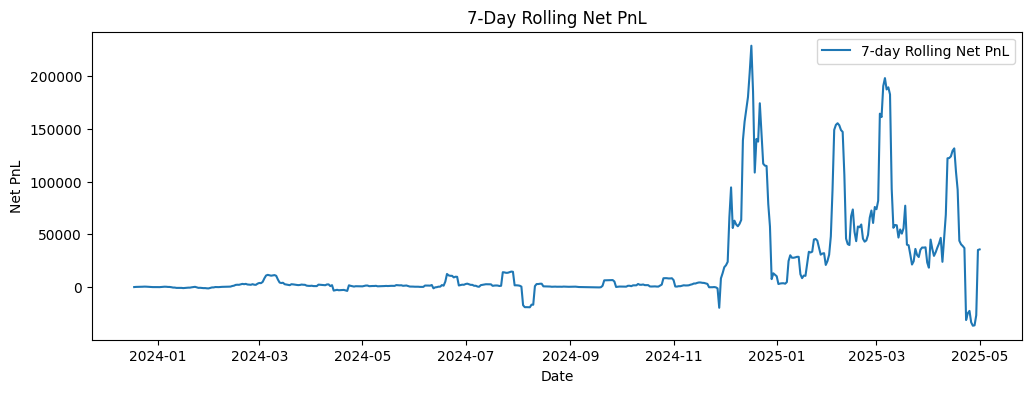

In [50]:
# Rolling net PnL plot
plt.figure(figsize=(12,4))
plt.plot(daily['date'], daily['net_pnl'].rolling(7).mean(), label='7-day Rolling Net PnL')
plt.xlabel('Date')
plt.ylabel('Net PnL')
plt.title('7-Day Rolling Net PnL')
plt.legend()
plt.savefig(f"{base_path}/outputs/netpnl_7d.png", bbox_inches='tight')
plt.show()


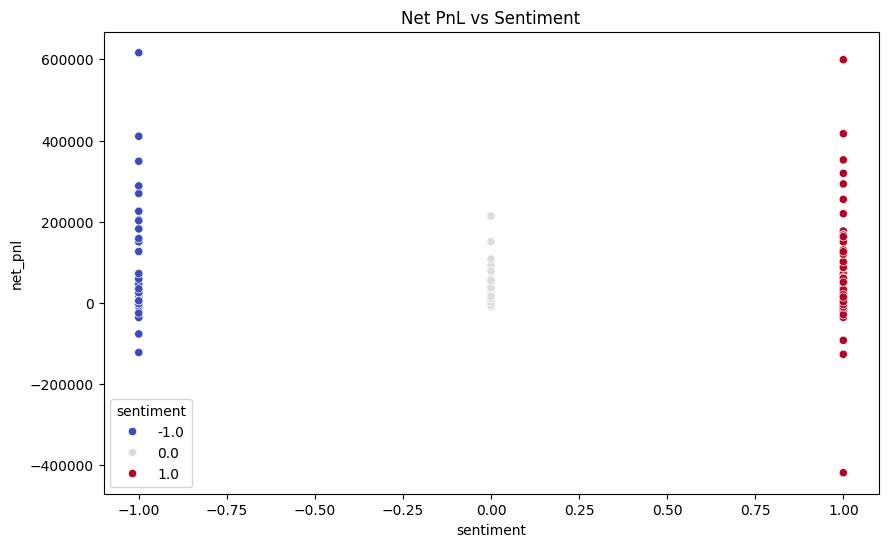

In [51]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=daily, x='sentiment', y='net_pnl', hue='sentiment', palette='coolwarm')
plt.title('Net PnL vs Sentiment')
plt.savefig(f"{base_path}/outputs/netpnl_vs_sentiment.png", bbox_inches='tight')
plt.show()


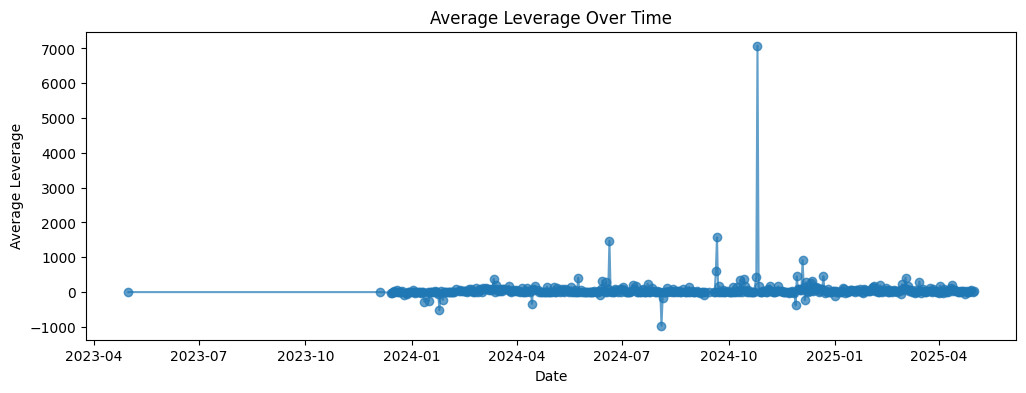

In [52]:
plt.figure(figsize=(12,4))
plt.plot(daily['date'], daily['avg_leverage'], marker='o', linestyle='-', alpha=0.7)
plt.title('Average Leverage Over Time')
plt.xlabel('Date')
plt.ylabel('Average Leverage')
plt.savefig(f"{base_path}/outputs/avg_leverage_over_time.png", bbox_inches='tight')
plt.show()


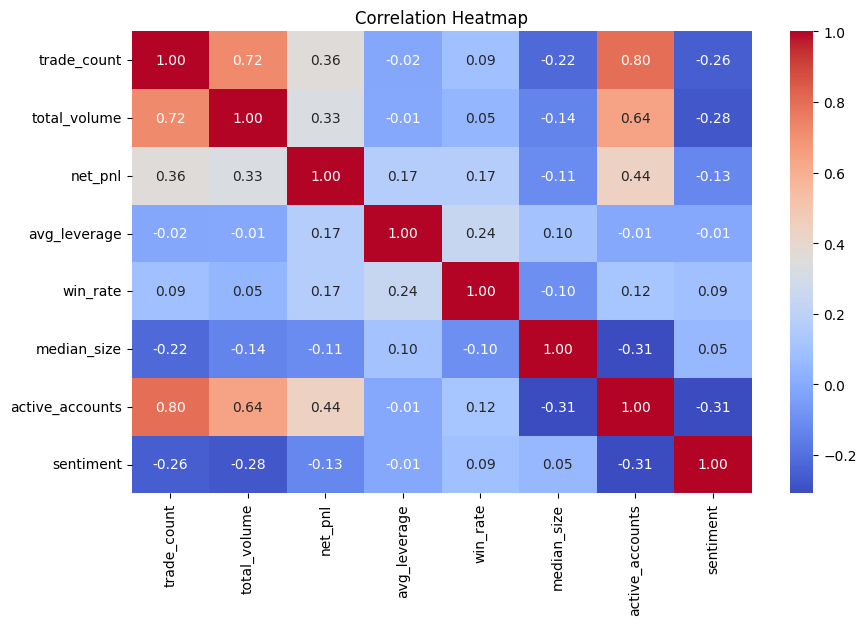

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(daily[['trade_count','total_volume','net_pnl','avg_leverage','win_rate','median_size','active_accounts','sentiment']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig(f"{base_path}/outputs/correlation_heatmap.png", bbox_inches='tight')
plt.show()


/tmp/ipython-input-1583975514.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily, x='sentiment', y='win_rate', palette='coolwarm')


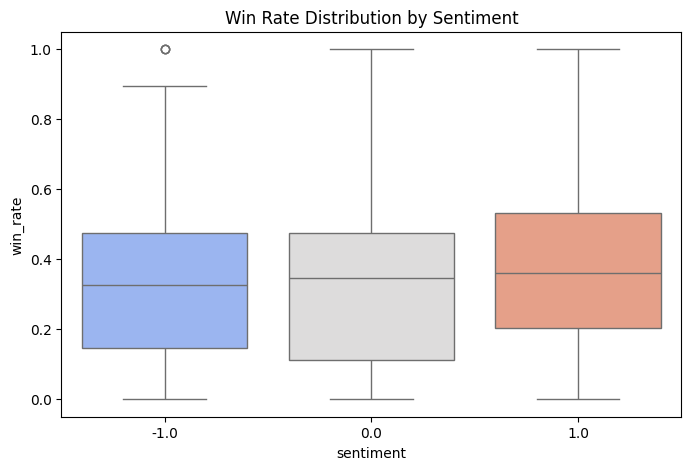

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(data=daily, x='sentiment', y='win_rate', palette='coolwarm')
plt.title('Win Rate Distribution by Sentiment')
plt.savefig(f"{base_path}/outputs/winrate_by_sentiment.png", bbox_inches='tight')
plt.show()


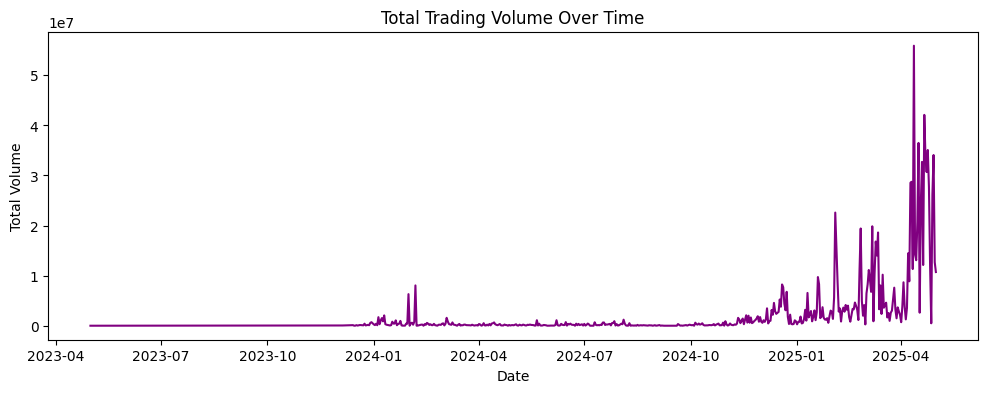

In [55]:
plt.figure(figsize=(12,4))
plt.plot(daily['date'], daily['total_volume'], color='purple')
plt.title('Total Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.savefig(f"{base_path}/outputs/total_volume_over_time.png", bbox_inches='tight')
plt.show()


/tmp/ipython-input-440494849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=active_acc.values, y=active_acc.index, palette='viridis')


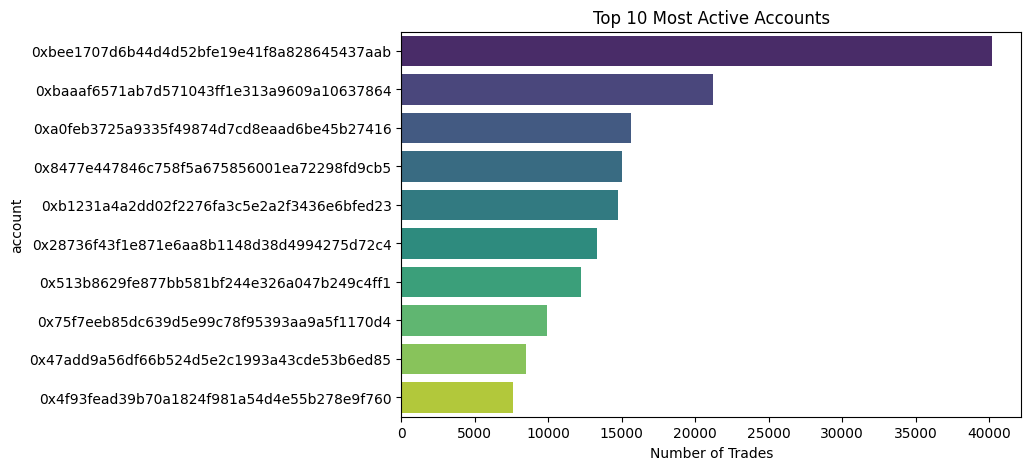

In [56]:
# This will only work if your trades-level dataset is still available
try:
    trades_df = pd.read_csv(f"{base_path}/csv_files/trades_clean.csv", parse_dates=['date'])
    active_acc = trades_df.groupby('account').size().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(x=active_acc.values, y=active_acc.index, palette='viridis')
    plt.title('Top 10 Most Active Accounts')
    plt.xlabel('Number of Trades')
    plt.savefig(f"{base_path}/outputs/top_active_accounts.png", bbox_inches='tight')
    plt.show()
except FileNotFoundError:
    print("Trades-level dataset not found — skipping this plot.")


/tmp/ipython-input-3679896057.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=daily, x='sentiment', palette='coolwarm')


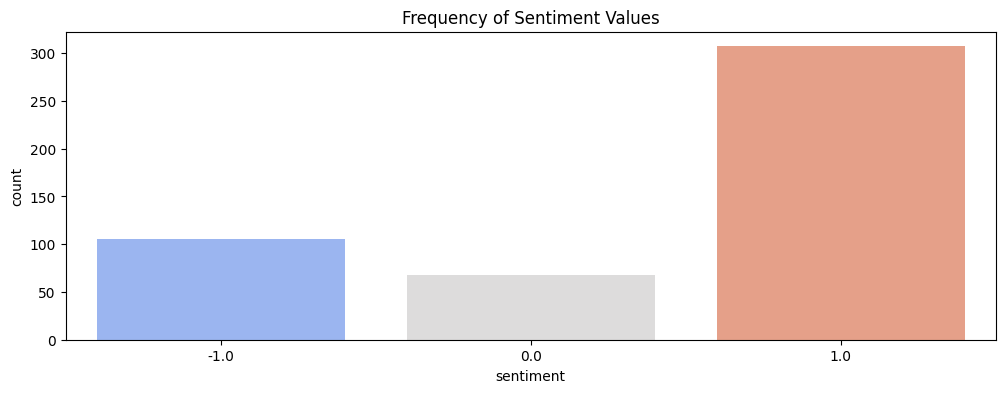

In [57]:
plt.figure(figsize=(12,4))
sns.countplot(data=daily, x='sentiment', palette='coolwarm')
plt.title('Frequency of Sentiment Values')
plt.savefig(f"{base_path}/outputs/sentiment_frequency.png", bbox_inches='tight')
plt.show()


In [58]:
from scipy.stats import spearmanr

corr, pval = spearmanr(daily['sentiment'], daily['net_pnl'])
print(f"Spearman correlation: {corr:.3f}, p-value: {pval:.3f}")


Spearman correlation: -0.073, p-value: 0.112


In [59]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

for train_idx, test_idx in tscv.split(X):
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict(X.iloc[test_idx])
    rmse = np.sqrt(mean_squared_error(y.iloc[test_idx], preds))
    rmses.append(rmse)

for i in range(len(rmses)):
    print(f"Fold {i+1} RMSE: {rmses[i]:.3f}")
print(f"Mean RMSE: {np.mean(rmses):.3f}")

Fold 1 RMSE: 4234.372
Fold 2 RMSE: 15966.126
Fold 3 RMSE: 3613.360
Fold 4 RMSE: 112258.134
Fold 5 RMSE: 72029.915
Fold 6 RMSE: 4234.372
Fold 7 RMSE: 15966.126
Fold 8 RMSE: 3613.360
Fold 9 RMSE: 112258.134
Fold 10 RMSE: 72029.915
Fold 11 RMSE: 4234.372
Fold 12 RMSE: 15966.126
Fold 13 RMSE: 3613.360
Fold 14 RMSE: 112258.134
Fold 15 RMSE: 72029.915
Fold 16 RMSE: 4234.372
Fold 17 RMSE: 15966.126
Fold 18 RMSE: 3613.360
Fold 19 RMSE: 112258.134
Fold 20 RMSE: 72029.915
Fold 21 RMSE: 4234.372
Fold 22 RMSE: 15966.126
Fold 23 RMSE: 3613.360
Fold 24 RMSE: 112258.134
Fold 25 RMSE: 72029.915
Mean RMSE: 41620.381


In [60]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r {base_path} /content/drive/MyDrive/
print("Backup completed to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Backup completed to Google Drive.


In [61]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
